In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement import basic, plot_basic
from kid_readout.measurement.io import npy

In [2]:
npd = npy.NumpyDirectory('/data/readout/2017-12-04_145404_mmw_eccosorb.npd/')

In [3]:
print(npd.metadata.script_code)

"""
Measure one group of resonances simultaneously.
"""
from __future__ import division
import time

import numpy as np

from kid_readout.roach import analog, hardware_tools, tools
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware, starcryo_temps
from equipment.srs import lockin
from equipment.custom import mmwave_source
from kid_readout.settings import LOCKIN_SERIAL_PORT, CRYOGENIC_HWP_MOTOR_SERIAL_PORT
import resonances

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'mmw_eccosorb'
df_baseband_target = 30e3
f_sweep_span_maximum = 3e6
f_lo_spacing = 2.5e3
f_baseband_minimum = 10e6  # Keep the tones away from the LO by at least this frequency.
f_baseband_maximum = 200e6  # Place dummy tones above this frequency
sweep_length_seconds = 0.01
stream_length_seconds = 5

# Resonance frequencies
band_dict = resonances.dict_180_mK
fractional_frequency_shift = 0
for f_center in ban

In [4]:
npd.node_names()

['SweepStreamList0',
 'ADCSnap1',
 'SweepStreamList2',
 'ADCSnap3',
 'SweepStreamList4',
 'ADCSnap5',
 'SweepStreamList6',
 'ADCSnap7']

In [5]:
all_ssl = [npd.read(name) for name in npd.node_names() if name.startswith('SweepStreamList')]

In [6]:
def plot_band(ssl):
    num_resonators = ssl.sweep.num_channels - ssl.state.num_dummy_frequencies
    fig, axes = plt.subplots(num_resonators, 3, figsize=(6, 2 * num_resonators),
                             gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    sss = {}
    for number, (ax_off, ax_mod, ax_on) in enumerate(axes):
        sss_off = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[0][number])
        plot_basic.sss_complex_plane(axis=ax_off, sss=sss_off)
        ax_off.set_title("{:d} off, {:.1f} dB".format(number, sss_off.stream.roach_state.dac_attenuation),
                         fontsize='xx-small')
        sss_mod = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[1][number])
        plot_basic.sss_complex_plane(axis=ax_mod, sss=sss_mod)
        ax_mod.set_title("{:d} mod, {:.1f} dB".format(number, sss_mod.stream.roach_state.dac_attenuation),
                         fontsize='xx-small') 
        sss_on = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[2][number])
        plot_basic.sss_complex_plane(axis=ax_on, sss=sss_on)
        ax_on.set_title("{:d} on, {:.1f} dB".format(number, sss_off.stream.roach_state.dac_attenuation),
                        fontsize='xx-small')
        for ax in (ax_off, ax_mod, ax_on):
            ax.tick_params(labelsize='xx-small')
        sss[number] = (sss_off, sss_mod, sss_on)
    return fig, axes, sss

def plot_folded(ssl):
    num_resonators = ssl.sweep.num_channels - ssl.state.num_dummy_frequencies
    fig, axes = plt.subplots(num_resonators, 1, figsize=(2, 1 * num_resonators),
                             gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    for number, ax in enumerate(axes):
        sss_mod = basic.SingleSweepStream(sweep=ssl.sweep[number], stream=ssl.stream_list[1][number])
        x_fold = sss_mod.fold(sss_mod.x)
        q_fold = sss_mod.fold(sss_mod.q)
        time = sss_mod.stream.sample_time[:x_fold.size]
        ax.plot(1e3 * time, 1e6 * (x_fold - x_fold.mean()))
        ax.plot(1e3 * time, 1e6 * (q_fold - q_fold.mean()))
    axes[-1].set_xlabel('time / ms', fontsize='xx-small')
    axes[-1].set_ylabel('response', fontsize='xx-small')
    return fig, axes

# Temperatures

In [7]:
package_color = 'C0'
eccosorb_color = 'C1'
stepper_color = 'C2'

num_ssls = len(all_ssl)

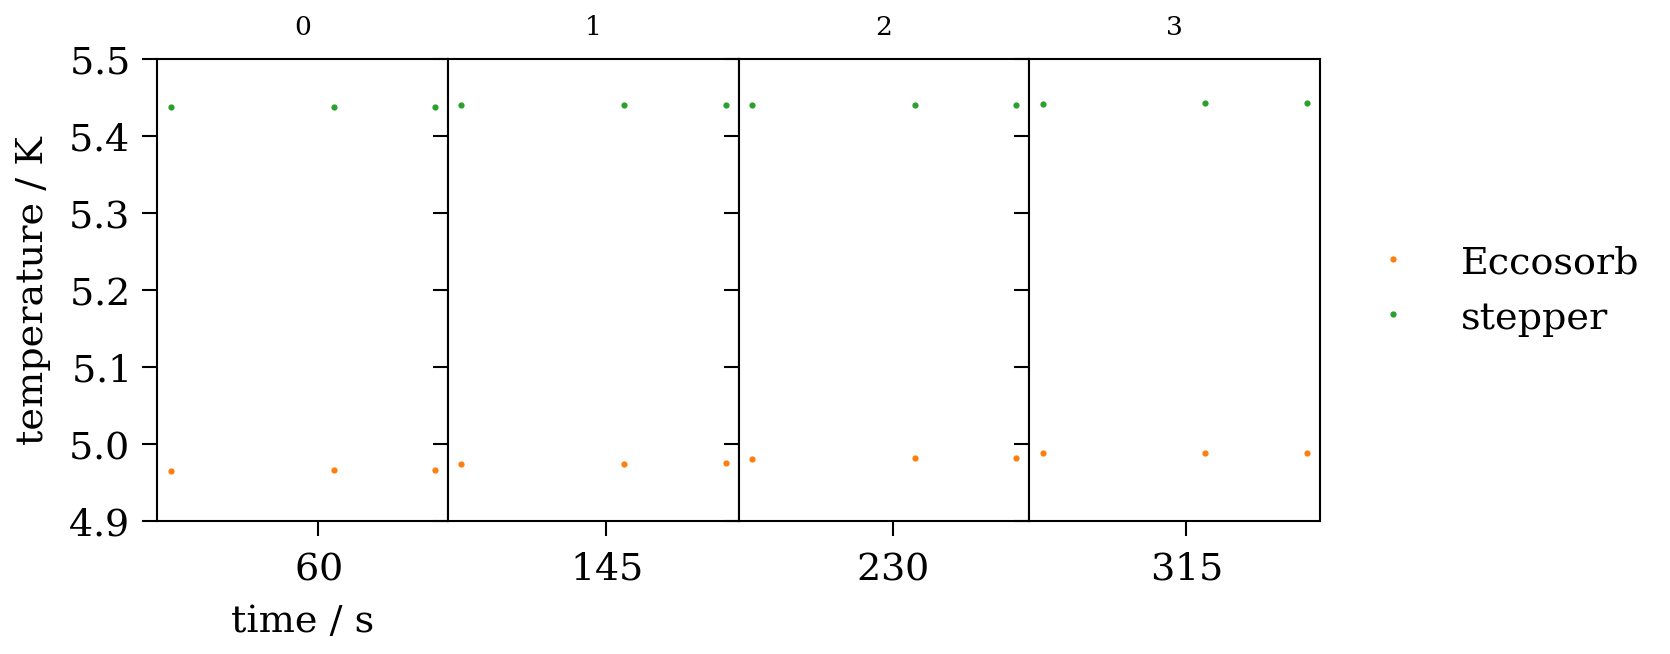

In [25]:
fig, diode_axes = plt.subplots(1, num_ssls, figsize=(5, 2),
                               gridspec_kw={'hspace': 0.4, 'wspace': 0})

t0 = all_ssl[0].start_epoch()
for index, ax in enumerate(diode_axes):
    ssl = all_ssl[index]
    time = [stream.epoch - t0 for stream in ssl.stream_list]
    eccosorb = [stream.state.temperature.eccosorb_diode_temperature for stream in ssl.stream_list]
    stepper = [stream.state.temperature.stepper_diode_temperature for stream in ssl.stream_list]
    ax.plot(time, eccosorb, '.', color=eccosorb_color, label='Eccosorb')
    ax.plot(time, stepper, '.', color=stepper_color, label='stepper')
    ax.set_title(str(index), fontsize='xx-small')

for ax in diode_axes:
    ax.set_ylim(4.9, 5.5)
    ax.set_xticks([ax.get_xticks().mean()])
for ax in diode_axes[1:]:
    ax.set_yticklabels([])
diode_axes[0].set_ylabel('temperature / K')
diode_axes[0].set_xlabel('time / s')
diode_axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

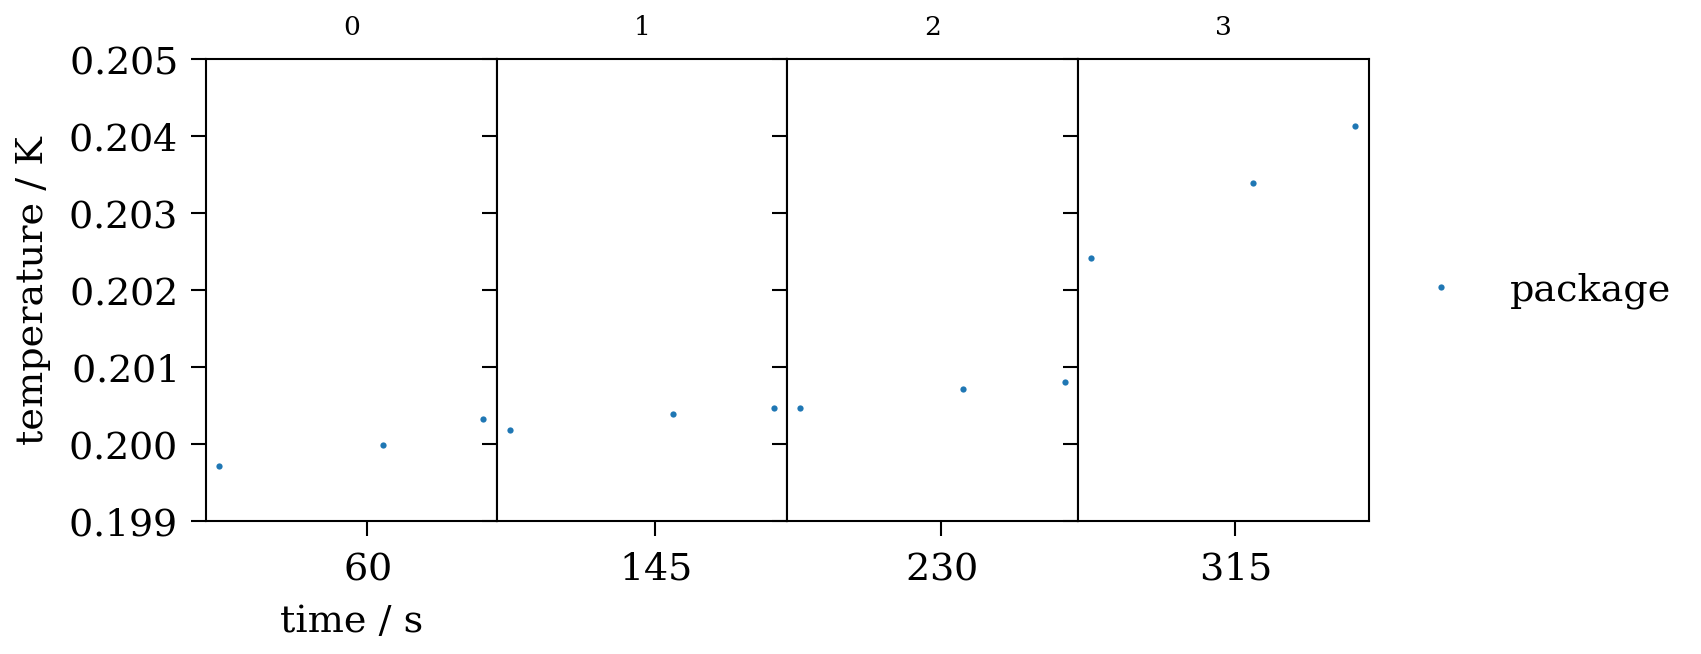

In [21]:
fig, package_axes = plt.subplots(1, num_ssls, figsize=(5, 2),
                               gridspec_kw={'hspace': 0.4, 'wspace': 0})

t0 = all_ssl[0].start_epoch()
for index, ax in enumerate(package_axes):
    ssl = all_ssl[index]
    time = [stream.epoch - t0 for stream in ssl.stream_list]
    package = [stream.state.temperature.package_ruox4550_temperature for stream in ssl.stream_list]
    ax.plot(time, package, '.', color=package_color, label='package')
    ax.set_title(str(index), fontsize='xx-small')

for ax in package_axes:
    ax.set_ylim(0.199, 0.205)
    ax.set_xticks([ax.get_xticks().mean()])
for ax in package_axes[1:]:
    ax.set_yticklabels([])
package_axes[0].set_ylabel('temperature / K')
package_axes[0].set_xlabel('time / s')
package_axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Data

[1919.7192904236151, 2062.556282450485]


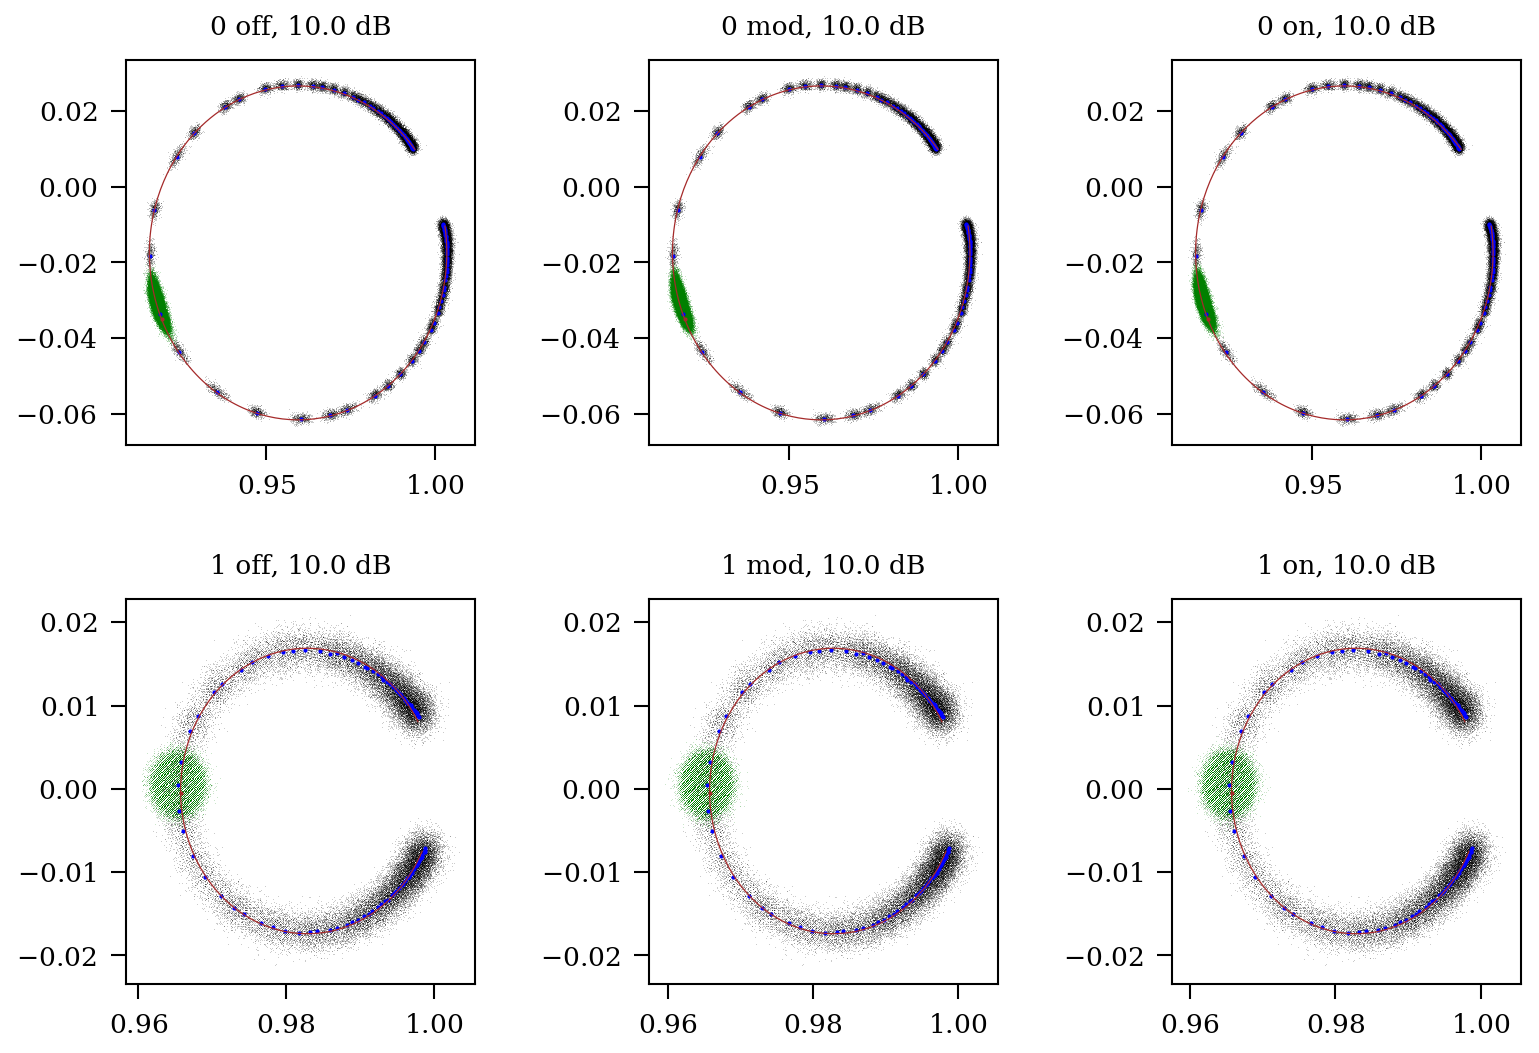

In [10]:
fig, axes, sss = plot_band(all_ssl[0])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[1919.7192904236151, 2062.556282450485]


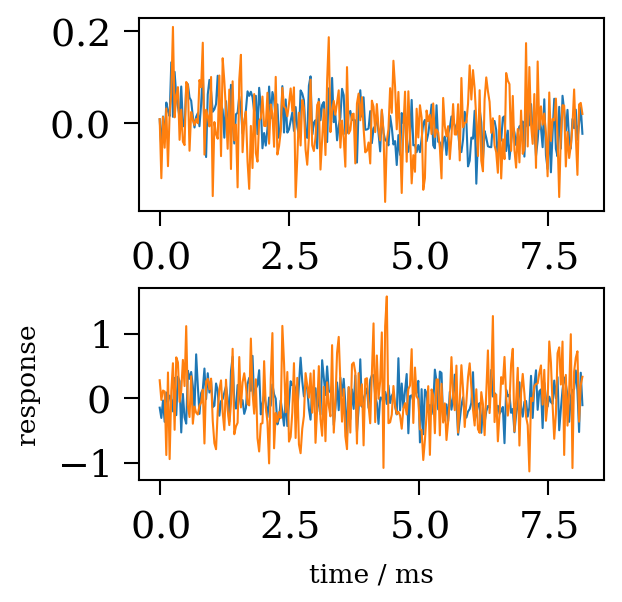

In [11]:
fig, axes = plot_folded(all_ssl[0])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2335.4877829564939, 2396.4894367335505]


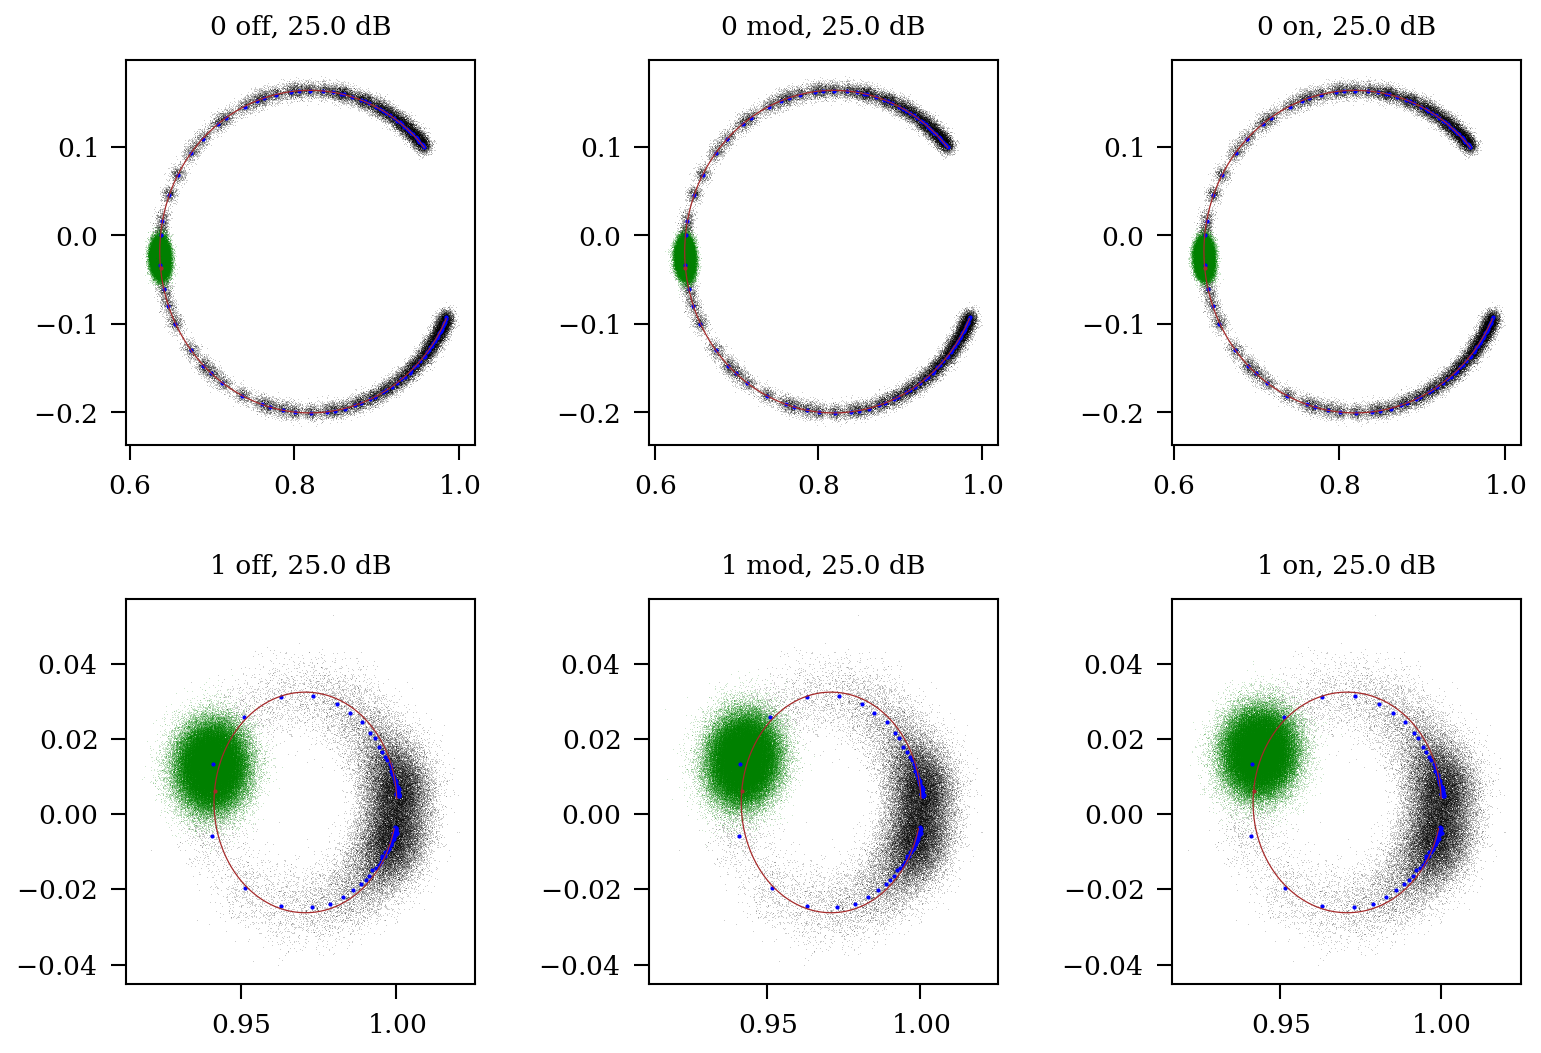

In [12]:
fig, axes, sss = plot_band(all_ssl[1])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2335.4877829564939, 2396.4894367335505]


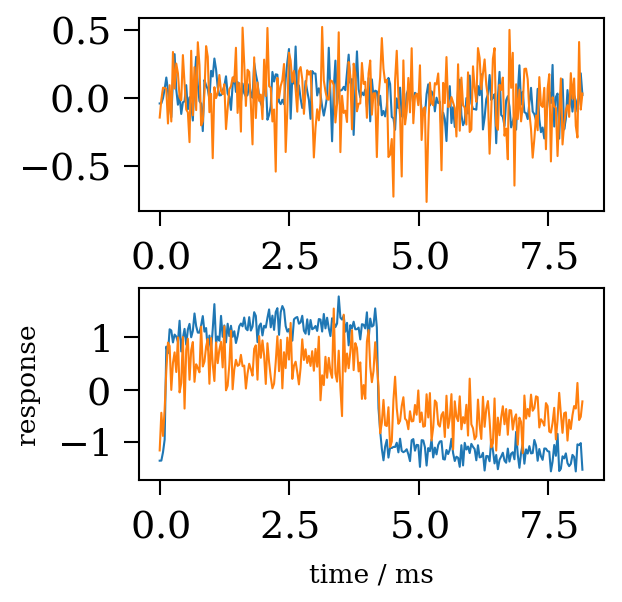

In [13]:
fig, axes = plot_folded(all_ssl[1])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2591.0750755355211, 2677.9725274793536]


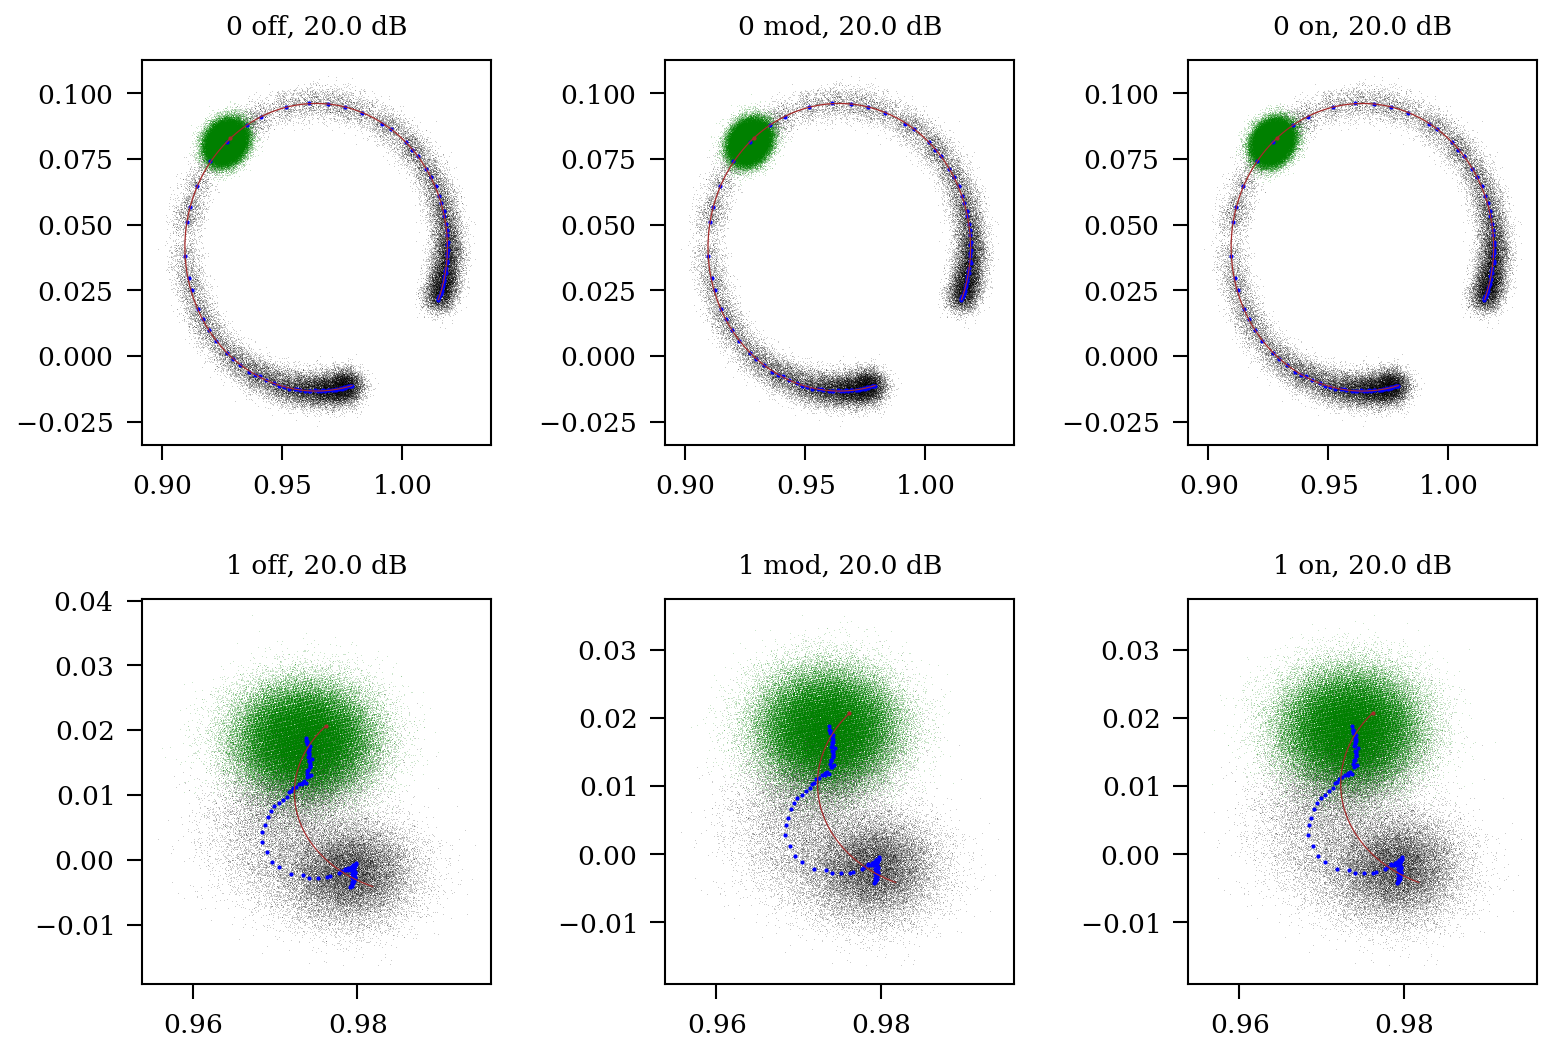

In [14]:
fig, axes, sss = plot_band(all_ssl[2])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2591.0750755355211, 2677.9725274793536]


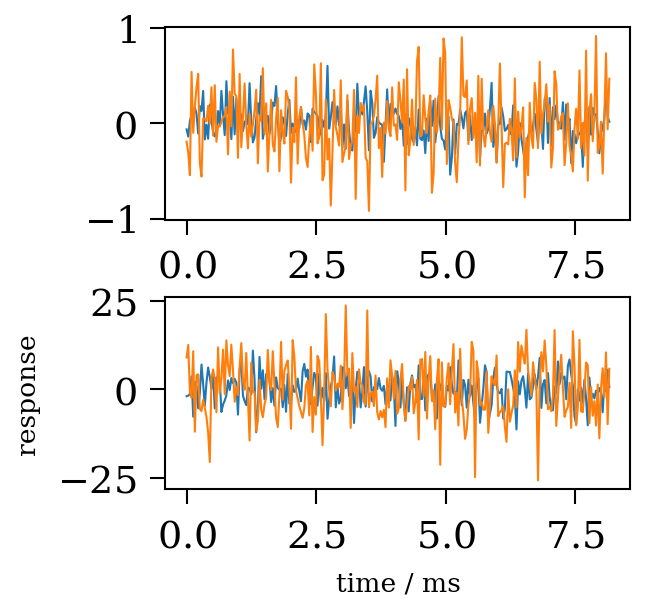

In [15]:
fig, axes = plot_folded(all_ssl[2])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2757.6291087898826, 2778.71411986271, 2792.4809230982096, 2816.1746242128365]


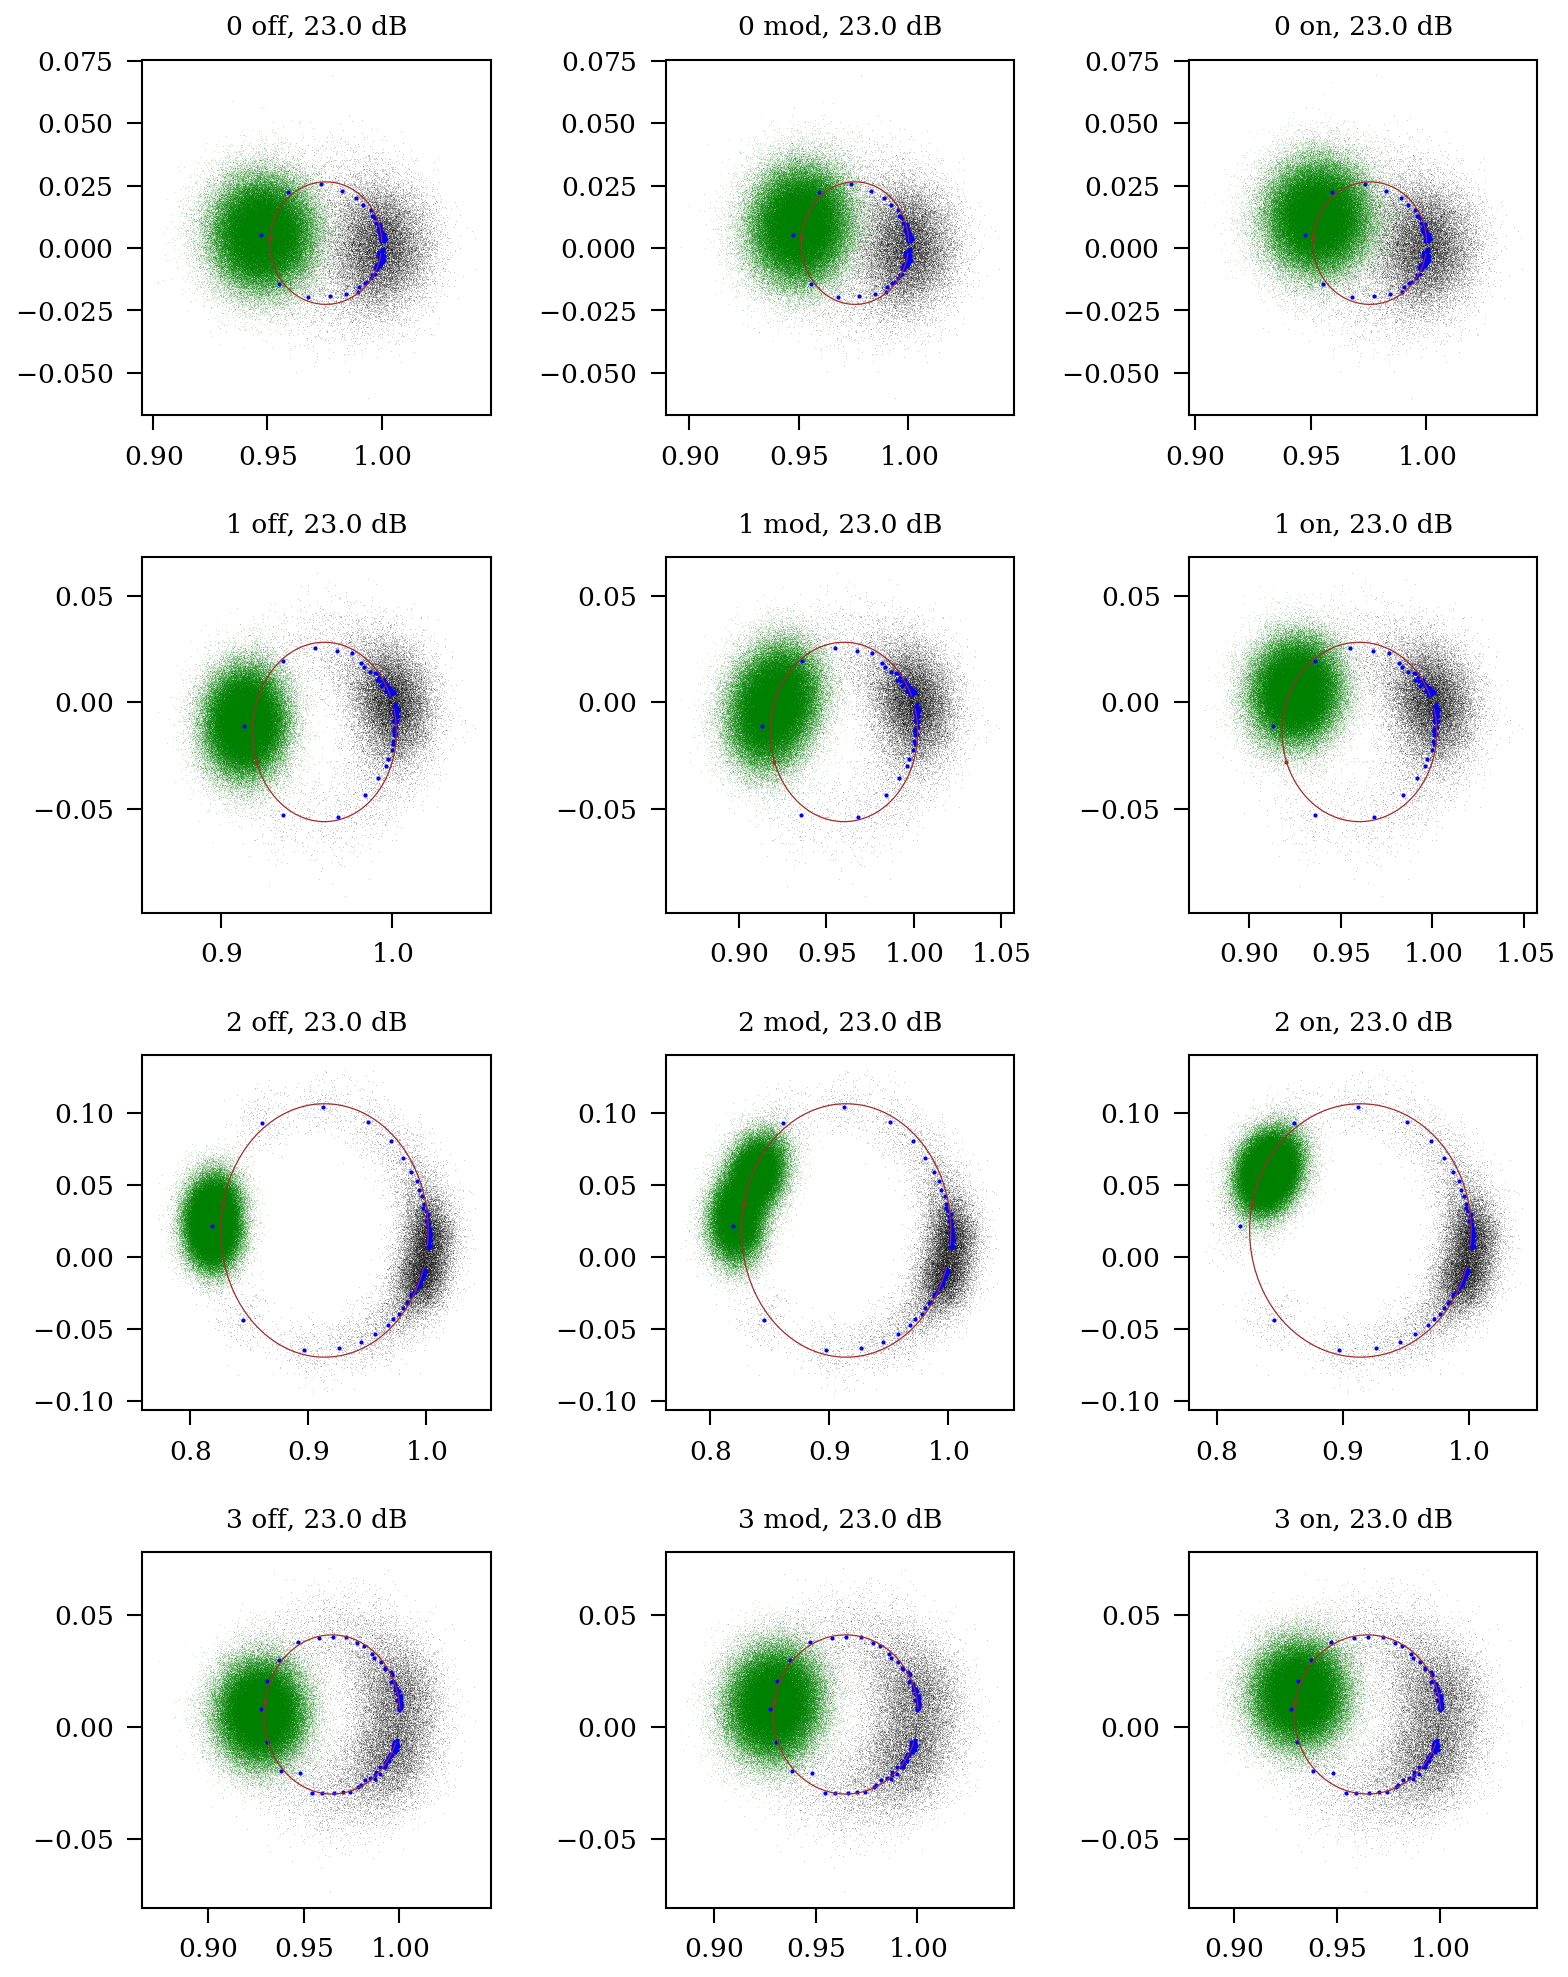

In [16]:
fig, axes, sss = plot_band(all_ssl[3])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))

[2757.6291087898826, 2778.71411986271, 2792.4809230982096, 2816.1746242128365]


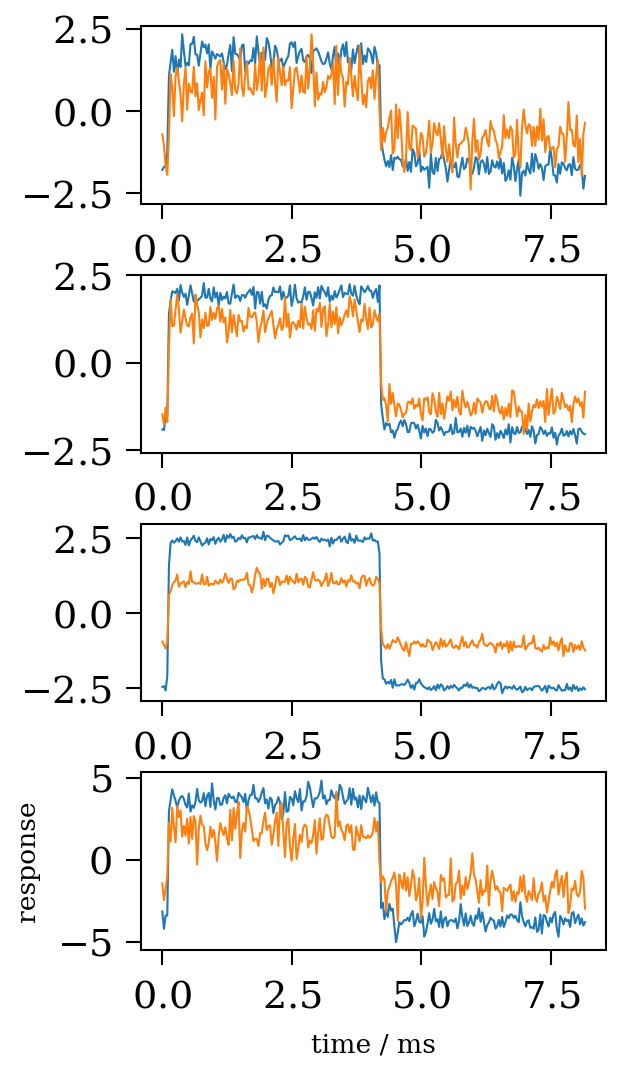

In [17]:
fig, axes = plot_folded(all_ssl[3])
print(sorted([1e-6 * sss_list[0].resonator.f_0 for sss_list in sss.values()]))